In [ ]:
import gc
gc.collect()

87030

# SetUp

In [ ]:
!pip install -q -U -r requirements.txt
# !pip install -q -U keras-cv

# Import Required Packages

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
import numpy as np
from PIL import Image
import shutil
from tqdm import tqdm
import random

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import layers, models, applications, optimizers
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score


# Constants

In [ ]:
DIR_PATH = '/content/drive/MyDrive/Colab Notebooks/'
TEST_DATA_DIR = DIR_PATH + "test_dataset/"
TRAIN_DATA_DIR = DIR_PATH + "train_dataset/"
AUGMENTED_DIR = DIR_PATH + "augmented_train_dataset"
AUTOTUNE = tf.data.AUTOTUNE

IMG_SIZE = (75, 75)
INPUT_SHAPE = IMG_SIZE + (3,)
EPOCHS = 200
BATCH_SIZE = 32
BUFFER_SIZE = 100

# Constants


# Load Data

In [ ]:
# Load training and validation datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 11052 files belonging to 2 classes.
Using 8842 files for training.
Found 11052 files belonging to 2 classes.
Using 2210 files for validation.


In [ ]:
# Get class names BEFORE applying map transformations
class_names = train_ds.class_names
class_names

['COVID', 'Normal']

In [ ]:
# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Data Preprocessing

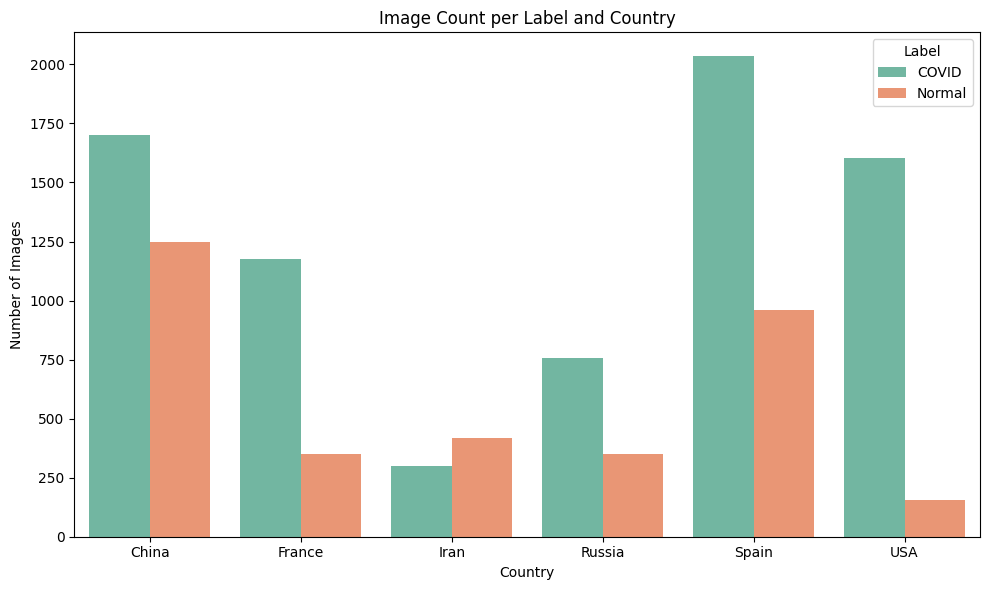

In [ ]:
# Initialize list to store counts
data = []

# Loop through labels and countries
for label in os.listdir(TRAIN_DATA_DIR):
    label_path = os.path.join(TRAIN_DATA_DIR, label)
    if not os.path.isdir(label_path):
        continue

    for country in os.listdir(label_path):
        country_path = os.path.join(label_path, country)
        if not os.path.isdir(country_path):
            continue

        count = len([
            f for f in os.listdir(country_path)
            if f.lower().endswith(('.jpg', '.png', '.jpeg'))
        ])
        data.append({"Label": label, "Country": country, "Count": count})

# Convert to DataFrame
df = pd.DataFrame(data)

# Sort for consistent plotting
df = df.sort_values(by=["Label", "Country"])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Country", y="Count", hue="Label", palette="Set2")
plt.title("Image Count per Label and Country")
plt.xlabel("Country")
plt.ylabel("Number of Images")
plt.legend(title="Label")
plt.tight_layout()
plt.show()


In [ ]:
df

,Label,Country,Count
0,COVID,China,1700
1,COVID,France,1176
2,COVID,Iran,301
3,COVID,Russia,756
4,COVID,Spain,2034
5,COVID,USA,1605
6,Normal,China,1249
7,Normal,France,350
8,Normal,Iran,417
9,Normal,Russia,350


In [ ]:
image_counts = defaultdict(int)

for label in ['COVID', 'Normal']:
    for country in os.listdir(os.path.join(TRAIN_DATA_DIR, label)):
        path = os.path.join(TRAIN_DATA_DIR, label, country)
        image_counts[(label, country)] = len([
            f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])

In [ ]:
# Identify max per label or globally

# Option 1: Max across all
global_max = max(image_counts.values())

# Option 2: Max per label
label_max = {
    label: max(v for (lbl, _), v in image_counts.items() if lbl == label)
    for label in ['COVID', 'Normal']
}


In [ ]:
def augment_image(img_path, augmentor):
    image = tf.keras.utils.load_img(img_path)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.image.resize(image, (224, 224))
    image = tf.expand_dims(image, 0)  # add batch dim
    aug_img = augmentor(image, training=True)
    return tf.squeeze(aug_img).numpy().astype(np.uint8)


In [ ]:
# Create Augmentor and Save
augmentor = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomTranslation(0.05, 0.05)
])

os.makedirs(AUGMENTED_DIR, exist_ok=True)

for (label, country), count in tqdm(image_counts.items()):
    src_dir = os.path.join(TRAIN_DATA_DIR, label, country)
    dst_dir = os.path.join(AUGMENTED_DIR, label, country)
    os.makedirs(dst_dir, exist_ok=True)

    images = [f for f in os.listdir(src_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Copy original files
    for img in images:
        shutil.copy(os.path.join(src_dir, img), os.path.join(dst_dir, img))

    # Augment if needed
    target = label_max[label]  # or use global_max
    num_to_generate = target - count

    for i in range(num_to_generate):
        img_to_augment = random.choice(images)
        augmented_img = augment_image(os.path.join(src_dir, img_to_augment), augmentor)
        Image.fromarray(augmented_img).save(os.path.join(dst_dir, f"aug_{i}_{img_to_augment}"))


100%|██████████| 12/12 [11:21<00:00, 56.82s/it]


In [ ]:
# Count images in original and augmented datasets
def get_image_counts(base_dir):
    counts = []
    for label in ['COVID', 'Normal']:
        label_path = os.path.join(base_dir, label)
        if not os.path.exists(label_path):
            continue
        for country in os.listdir(label_path):
            country_path = os.path.join(label_path, country)
            if not os.path.isdir(country_path):
                continue
            image_count = len([
                f for f in os.listdir(country_path)
                if f.lower().endswith(('.jpg', '.png', '.jpeg'))
            ])
            counts.append({'Label': label, 'Country': country, 'Count': image_count})
    return pd.DataFrame(counts)

# Count for original and augmented datasets
original_df = get_image_counts(TRAIN_DATA_DIR)
augmented_df = get_image_counts(AUGMENTED_DIR)

# Merge both DataFrames
comparison_df = original_df.merge(augmented_df, on=['Label', 'Country'], suffixes=('_Original', '_Augmented'))

# Save to CSV
comparison_df.to_csv("image_counts_comparison.csv", index=False)

comparison_df


,Label,Country,Count_Original,Count_Augmented
0,COVID,China,1700,2034
1,COVID,France,1176,2034
2,COVID,Iran,301,2034
3,COVID,Russia,756,2034
4,COVID,Spain,2034,2034
5,COVID,USA,1605,2034
6,Normal,China,1249,1249
7,Normal,France,350,1249
8,Normal,Iran,417,1249
9,Normal,Russia,350,1249


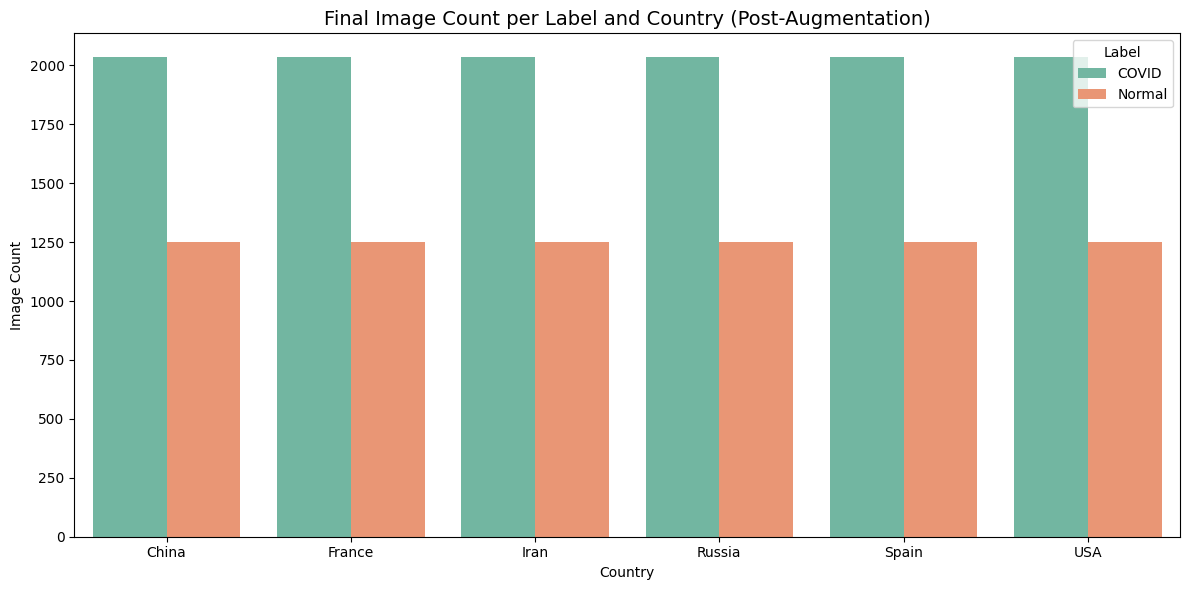

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=augmented_df, x="Country", y="Count", hue="Label", palette="Set2")
plt.title("Final Image Count per Label and Country (Post-Augmentation)", fontsize=14)
plt.ylabel("Image Count")
plt.xlabel("Country")
plt.legend(title="Label")
plt.tight_layout()
plt.show()

In [ ]:
TARGET_TOTAL = int(comparison_df[comparison_df['Label']=='COVID'].Count_Augmented.sum())
CURRENT_TOTAL = int(comparison_df[comparison_df['Label']=='Normal'].Count_Augmented.sum())
TARGET_TOTAL, CURRENT_TOTAL

(12204, 7494)

In [ ]:
# Set paths
NORMAL_PATH = AUGMENTED_DIR+"/Normal"
# How many more images to generate
EXTRA_REQUIRED = TARGET_TOTAL - CURRENT_TOTAL

# Build augmentation pipeline
augmentor = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomTranslation(0.05, 0.05)
])

# Helper function
def augment_image(img_path):
    image = tf.keras.utils.load_img(img_path)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.image.resize(image, (224, 224))
    image = tf.expand_dims(image, 0)
    augmented = augmentor(image, training=True)
    return tf.squeeze(augmented).numpy().astype('uint8')

# Distribute augmentation across countries
normal_files = []
for country in os.listdir(NORMAL_PATH):
    country_path = os.path.join(NORMAL_PATH, country)
    files = [f for f in os.listdir(country_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    for f in files:
        normal_files.append((os.path.join(country_path, f), country))

# Generate required augmented images
for i in tqdm(range(EXTRA_REQUIRED)):
    img_path, country = random.choice(normal_files)
    aug_img = augment_image(img_path)

    out_path = os.path.join(NORMAL_PATH, country, f"aug_extra_{i}_{os.path.basename(img_path)}")
    Image.fromarray(aug_img).save(out_path)


100%|██████████| 4710/4710 [04:16<00:00, 18.37it/s]


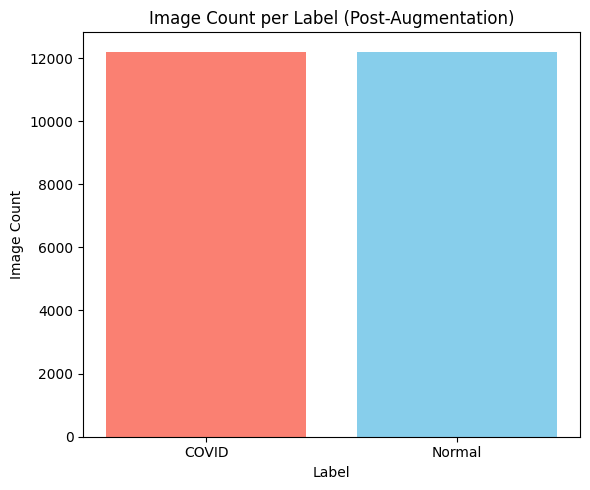

    Label  Image_Count
0   COVID        12204
1  Normal        12204


In [ ]:
# Count images in each label folder
label_counts = []
for label in ['COVID', 'Normal']:
    label_path = os.path.join(AUGMENTED_DIR, label)
    total_count = 0
    for country in os.listdir(label_path):
        country_path = os.path.join(label_path, country)
        if os.path.isdir(country_path):
            count = len([
                f for f in os.listdir(country_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            total_count += count
    label_counts.append({'Label': label, 'Image_Count': total_count})

# DataFrame for plotting
df_label = pd.DataFrame(label_counts)

# Plot
plt.figure(figsize=(6, 5))
plt.bar(df_label['Label'], df_label['Image_Count'], color=['salmon', 'skyblue'])
plt.title("Image Count per Label (Post-Augmentation)")
plt.xlabel("Label")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()

print(df_label)

<Figure size 1200x600 with 0 Axes>

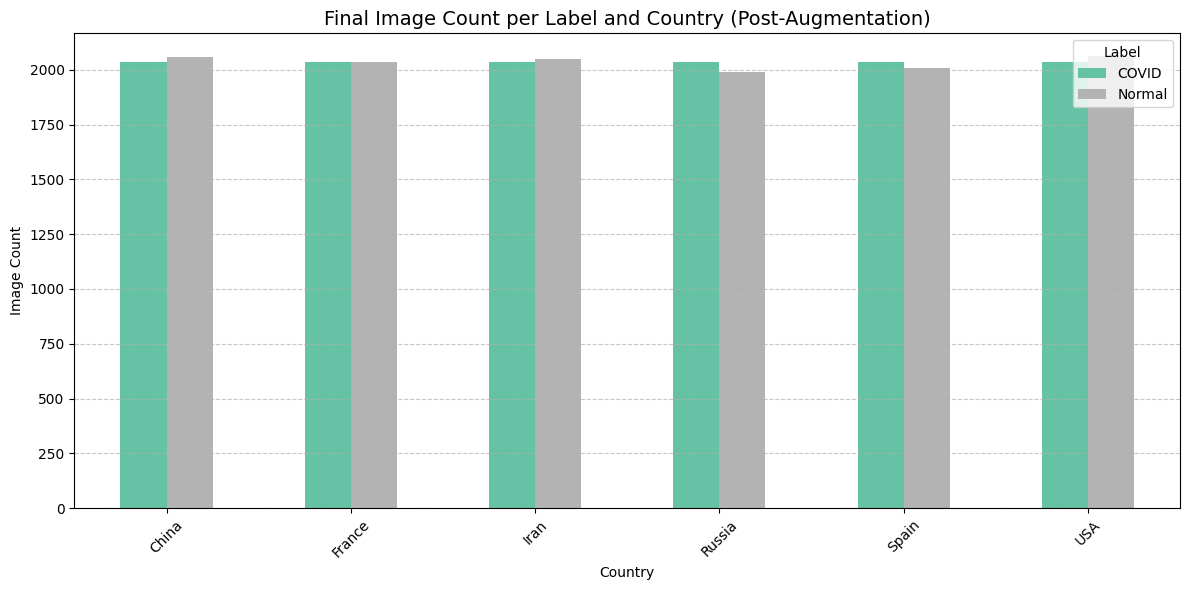

In [ ]:

# Count images per label and country
data = []
for label in ['COVID', 'Normal']:
    label_path = os.path.join(AUGMENTED_DIR, label)
    if os.path.isdir(label_path):
        for country in os.listdir(label_path):
            country_path = os.path.join(label_path, country)
            if os.path.isdir(country_path):
                count = len([
                    f for f in os.listdir(country_path)
                    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
                ])
                data.append({'Label': label, 'Country': country, 'Image_Count': count})

# Convert to DataFrame
df = pd.DataFrame(data)

# Plot grouped bar chart
plt.figure(figsize=(12, 6))
pivot_df = df.pivot(index='Country', columns='Label', values='Image_Count').fillna(0)
pivot_df.plot(kind='bar', figsize=(12, 6), colormap='Set2')

plt.title('Final Image Count per Label and Country (Post-Augmentation)', fontsize=14)
plt.xlabel('Country')
plt.ylabel('Image Count')
plt.xticks(rotation=45)
plt.legend(title='Label')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
df

,Label,Country,Image_Count
0,COVID,China,2034
1,COVID,France,2034
2,COVID,Iran,2034
3,COVID,Russia,2034
4,COVID,Spain,2034
5,COVID,USA,2034
6,Normal,China,2056
7,Normal,France,2037
8,Normal,Iran,2049
9,Normal,Russia,1991


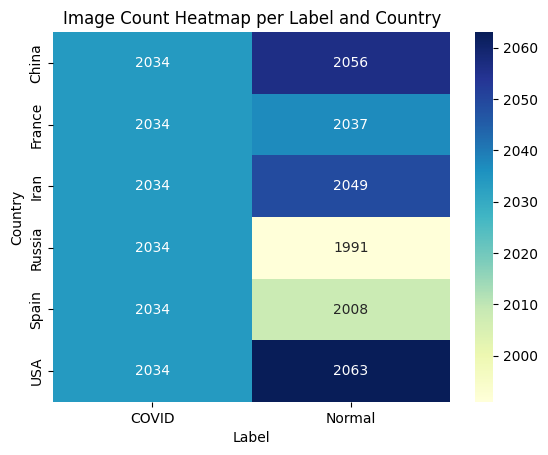

In [ ]:
pivot_df = df.pivot(index='Country', columns='Label', values='Image_Count')
sns.heatmap(pivot_df, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Image Count Heatmap per Label and Country")
plt.ylabel("Country")
plt.xlabel("Label")
plt.show()

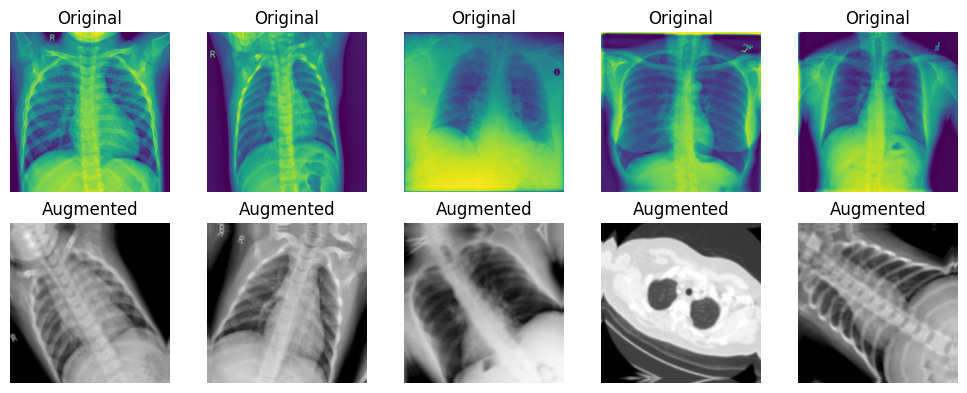

In [ ]:
def show_augmented_examples(label='Normal', country='USA', n=5):
    original_path = os.path.join(TRAIN_DATA_DIR, label, country)
    augmented_path = os.path.join(AUGMENTED_DIR, label, country)

    original_imgs = sorted([img for img in os.listdir(original_path) if not img.startswith("aug")])
    augmented_imgs = sorted([img for img in os.listdir(augmented_path) if img.startswith("aug")])

    plt.figure(figsize=(10, 4))
    for i in range(n):
        orig_img = Image.open(os.path.join(original_path, random.choice(original_imgs)))
        aug_img = Image.open(os.path.join(augmented_path, random.choice(augmented_imgs)))

        plt.subplot(2, n, i + 1)
        plt.imshow(orig_img)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(2, n, i + 1 + n)
        plt.imshow(aug_img)
        plt.title("Augmented")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
show_augmented_examples(label='Normal', country='USA', n=5)